# Customer Segmentation — Credit Card Dataset

## 1 · Setup & Data Loading

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.manifold import TSNE
import umap

import kagglehub
import os

sns.set_style("whitegrid")
plt.rcParams.update({
    "figure.figsize": (8, 6),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "font.size": 11,
})

In [2]:
path = kagglehub.dataset_download("arjunbhasin2013/ccdata")


csv_file = [f for f in os.listdir(path) if f.endswith(".csv")][0]
df = pd.read_csv(os.path.join(path, csv_file))
df.head()

Using Colab cache for faster access to the 'ccdata' dataset.


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
# df = pd.read_csv('CC GENERAL.csv')
# df.head()

### Variable Descriptions

1.  **CUST_ID**: Identification of the Credit Card holder (Categorical).

2.  **BALANCE**: Balance amount left in the account to make purchases.

3.  **BALANCE_FREQUENCY**: How frequently the Balance is updated (score between 0 and 1, where 1 = frequently updated).

4.  **PURCHASES**: Total amount of purchases made from the account.
5.  **ONEOFF_PURCHASES**: Maximum purchase amount done in a single transaction (one-go).
6.  **INSTALLMENTS_PURCHASES**: Amount of purchases done in installments.
7.  **CASH_ADVANCE**: Cash in advance given by the user (withdrawing cash using the card).
8.  **PURCHASES_FREQUENCY**: How frequently purchases are being made (score between 0 and 1).
9.  **ONEOFF_PURCHASES_FREQUENCY**: How frequently purchases happen in "one-go" (score between 0 and 1).
10. **PURCHASES_INSTALLMENTS_FREQUENCY**: How frequently purchases in installments are being done (score between 0 and 1).
11. **CASH_ADVANCE_FREQUENCY**: How frequently the "cash in advance" service is being used.
12. **CASH_ADVANCE_TRX**: Number of transactions made with "Cash in Advance".
13. **PURCHASES_TRX**: Number of purchase transactions made.
14. **CREDIT_LIMIT**: The credit limit assigned to the user.
15. **PAYMENTS**: Total amount of payments made by the user.
16. **MINIMUM_PAYMENTS**: Minimum amount of payments made by the user.
17. **PRC_FULL_PAYMENT**: Percentage of the full payment paid by the user.
18. **TENURE**: Tenure of credit card service for the user (number of months).

## 2 · Data Exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [5]:
missing = df.isnull().sum()
missing

,0
CUST_ID,0
BALANCE,0
BALANCE_FREQUENCY,0
PURCHASES,0
ONEOFF_PURCHASES,0
INSTALLMENTS_PURCHASES,0
CASH_ADVANCE,0
PURCHASES_FREQUENCY,0
ONEOFF_PURCHASES_FREQUENCY,0
PURCHASES_INSTALLMENTS_FREQUENCY,0


In [6]:
(missing / len(df) * 100).round(2)

,0
CUST_ID,0.00
BALANCE,0.00
BALANCE_FREQUENCY,0.00
PURCHASES,0.00
ONEOFF_PURCHASES,0.00
INSTALLMENTS_PURCHASES,0.00
CASH_ADVANCE,0.00
PURCHASES_FREQUENCY,0.00
ONEOFF_PURCHASES_FREQUENCY,0.00
PURCHASES_INSTALLMENTS_FREQUENCY,0.00


#### Why Are Values Missing?

In [7]:
miss_mp    = df[df["MINIMUM_PAYMENTS"].isna()]
present_mp = df[df["MINIMUM_PAYMENTS"].notna()]

compare_cols = ["BALANCE", "PURCHASES", "CASH_ADVANCE",
                "PAYMENTS", "CREDIT_LIMIT", "PRC_FULL_PAYMENT", "TENURE"]

comparison = pd.DataFrame({
    "Mean (missing)" : miss_mp[compare_cols].mean(),
    "Mean (present)" : present_mp[compare_cols].mean(),
    "Median (missing)": miss_mp[compare_cols].median(),
    "Median (present)": present_mp[compare_cols].median(),
}).round(2)

comparison

,Mean (missing),Mean (present),Median (missing),Median (present)
BALANCE,555.44,1601.04,16.85,916.75
PURCHASES,393.09,1025.32,130.40,375.24
CASH_ADVANCE,559.14,994.08,0.00,0.00
PAYMENTS,322.29,1784.27,0.00,896.30
CREDIT_LIMIT,3731.79,4522.09,3000.00,3000.00
PRC_FULL_PAYMENT,0.00,0.16,0.00,0.00
TENURE,11.06,11.53,12.00,12.00


In [8]:
miss_cl = df[df["CREDIT_LIMIT"].isna()]
miss_cl.T.style

,5203
CUST_ID,C15349
BALANCE,18.400472
BALANCE_FREQUENCY,0.166667
PURCHASES,0.000000
ONEOFF_PURCHASES,0.000000
INSTALLMENTS_PURCHASES,0.000000
CASH_ADVANCE,186.853063
PURCHASES_FREQUENCY,0.000000
ONEOFF_PURCHASES_FREQUENCY,0.000000
PURCHASES_INSTALLMENTS_FREQUENCY,0.000000


#### Missing-Value Analysis

**MINIMUM_PAYMENTS (313 missing — 3.5 %)**

The missingness is **not random**. Customers with missing MINIMUM_PAYMENTS tend to have:
- **Lower or zero PAYMENTS** — if a customer never made a payment, the bank cannot compute a minimum-payment amount.
- **Lower PURCHASES and BALANCE** — these accounts show less activity overall.
- This pattern is consistent with **inactive or newly opened accounts** where no billing cycle with a payment has occurred yet.

> **Conclusion**: The values are likely **Missing Not At Random (MNAR)** — the missingness is driven by the variable itself (no payment → no minimum payment). Imputing with the **median** (or 0) is a reasonable strategy.

---

**CREDIT_LIMIT (1 missing — 0.01 %)**

Only **one row** is affected. This is most likely a **data-entry or system error** — a single record that failed to capture the credit limit.

> **Conclusion**: The value is likely **Missing Completely At Random (MCAR)**. i will drop it.

In [9]:
df.duplicated().sum()

np.int64(0)

### Feature-Level EDA — Box Plots & Distributions

Features are split into **three subgroups** by their value range so plots within each group share a comparable scale.
Each subgroup shows box plots (outlier structure) → distributions (shape & skew) → full analysis.

In [10]:
numeric_cols = df.select_dtypes(include="number").columns.tolist()
ranges = df[numeric_cols].max() - df[numeric_cols].min()

high_value = ranges[ranges > 1000].index.tolist()
mid_value  = ranges[(ranges > 1) & (ranges <= 1000)].index.tolist()
low_value  = ranges[ranges <= 1].index.tolist()

if "CASH_ADVANCE_FREQUENCY" in mid_value:
    mid_value.remove("CASH_ADVANCE_FREQUENCY")
    low_value.append("CASH_ADVANCE_FREQUENCY")

print("High-Value Monetary:", high_value)
print("Transaction Counts :", mid_value)
print("Rate / Frequency   :", low_value)

High-Value Monetary: ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']
Transaction Counts : ['CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'TENURE']
Rate / Frequency   : ['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'PRC_FULL_PAYMENT', 'CASH_ADVANCE_FREQUENCY']


#### Subgroup 1 — High-Value Monetary Features (range > 1 000)

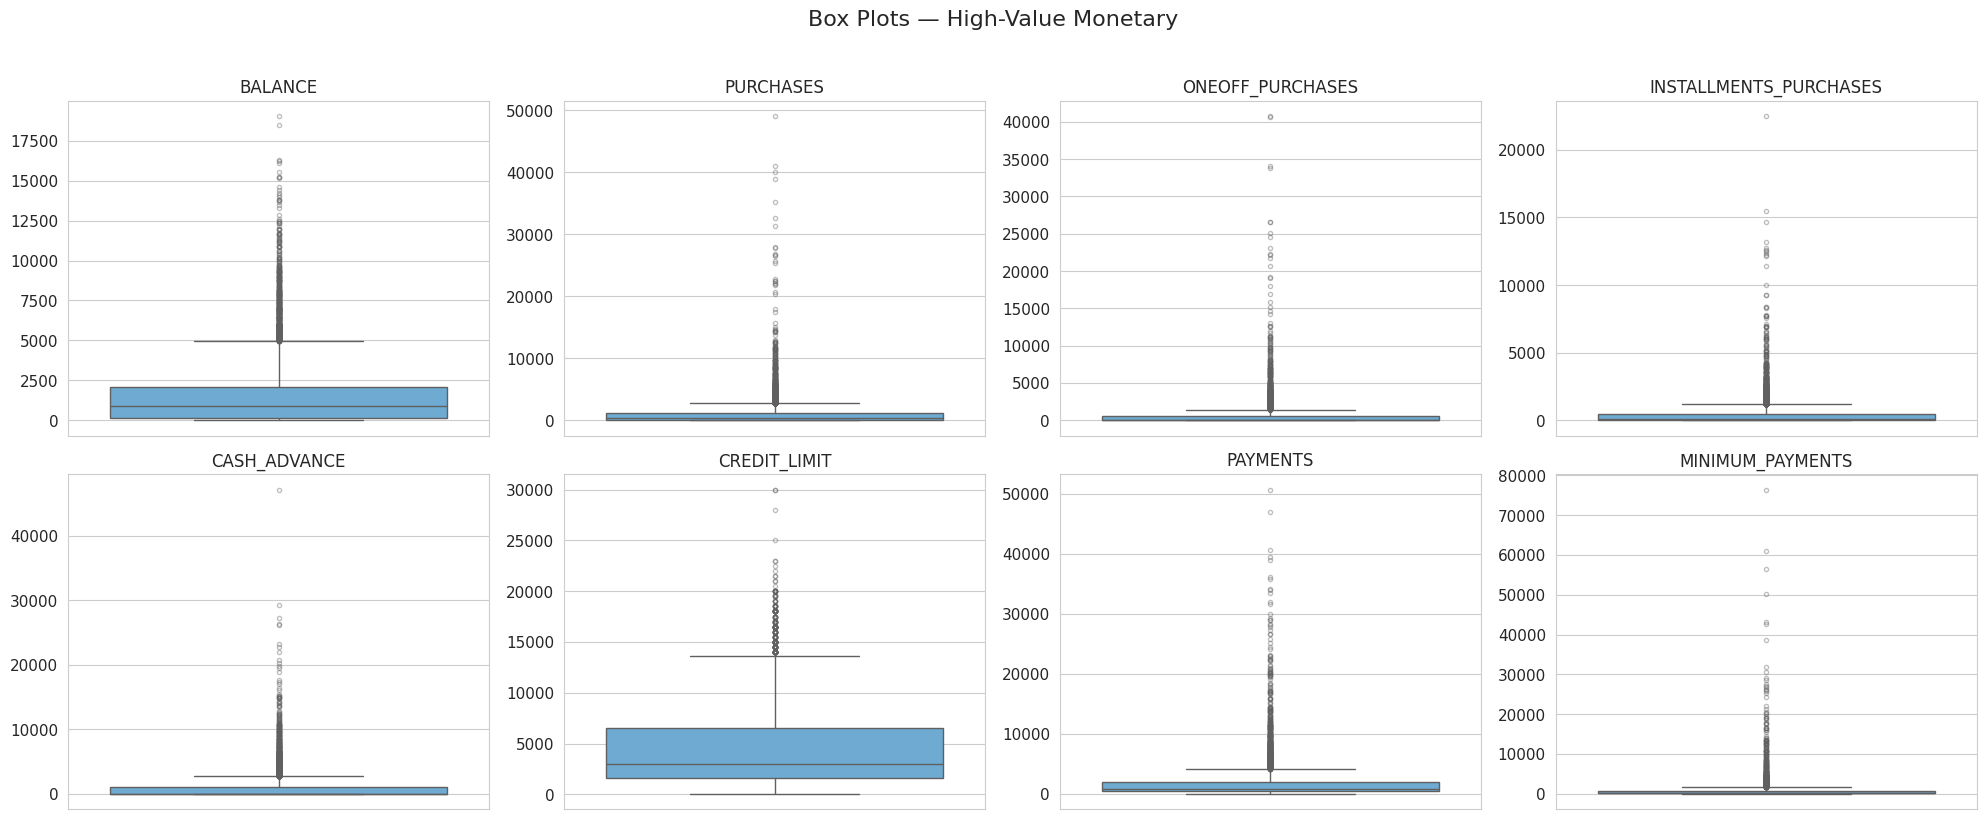

In [11]:
cols = high_value
n = len(cols)
ncols_g = min(n, 4)
nrows_g = (n + ncols_g - 1) // ncols_g

fig, axes = plt.subplots(nrows_g, ncols_g, figsize=(5*ncols_g, 4*nrows_g))
fig.suptitle("Box Plots — High-Value Monetary", fontsize=16, y=1.02)
axes = np.array(axes).flatten()
for i, col in enumerate(cols):
    sns.boxplot(y=df[col], ax=axes[i], color="#5DADE2",
                flierprops={"marker":"o","markersize":3,"alpha":0.4})
    axes[i].set_title(col, fontsize=12); axes[i].set_ylabel("")
for j in range(n, len(axes)): axes[j].set_visible(False)
plt.tight_layout(); plt.show()

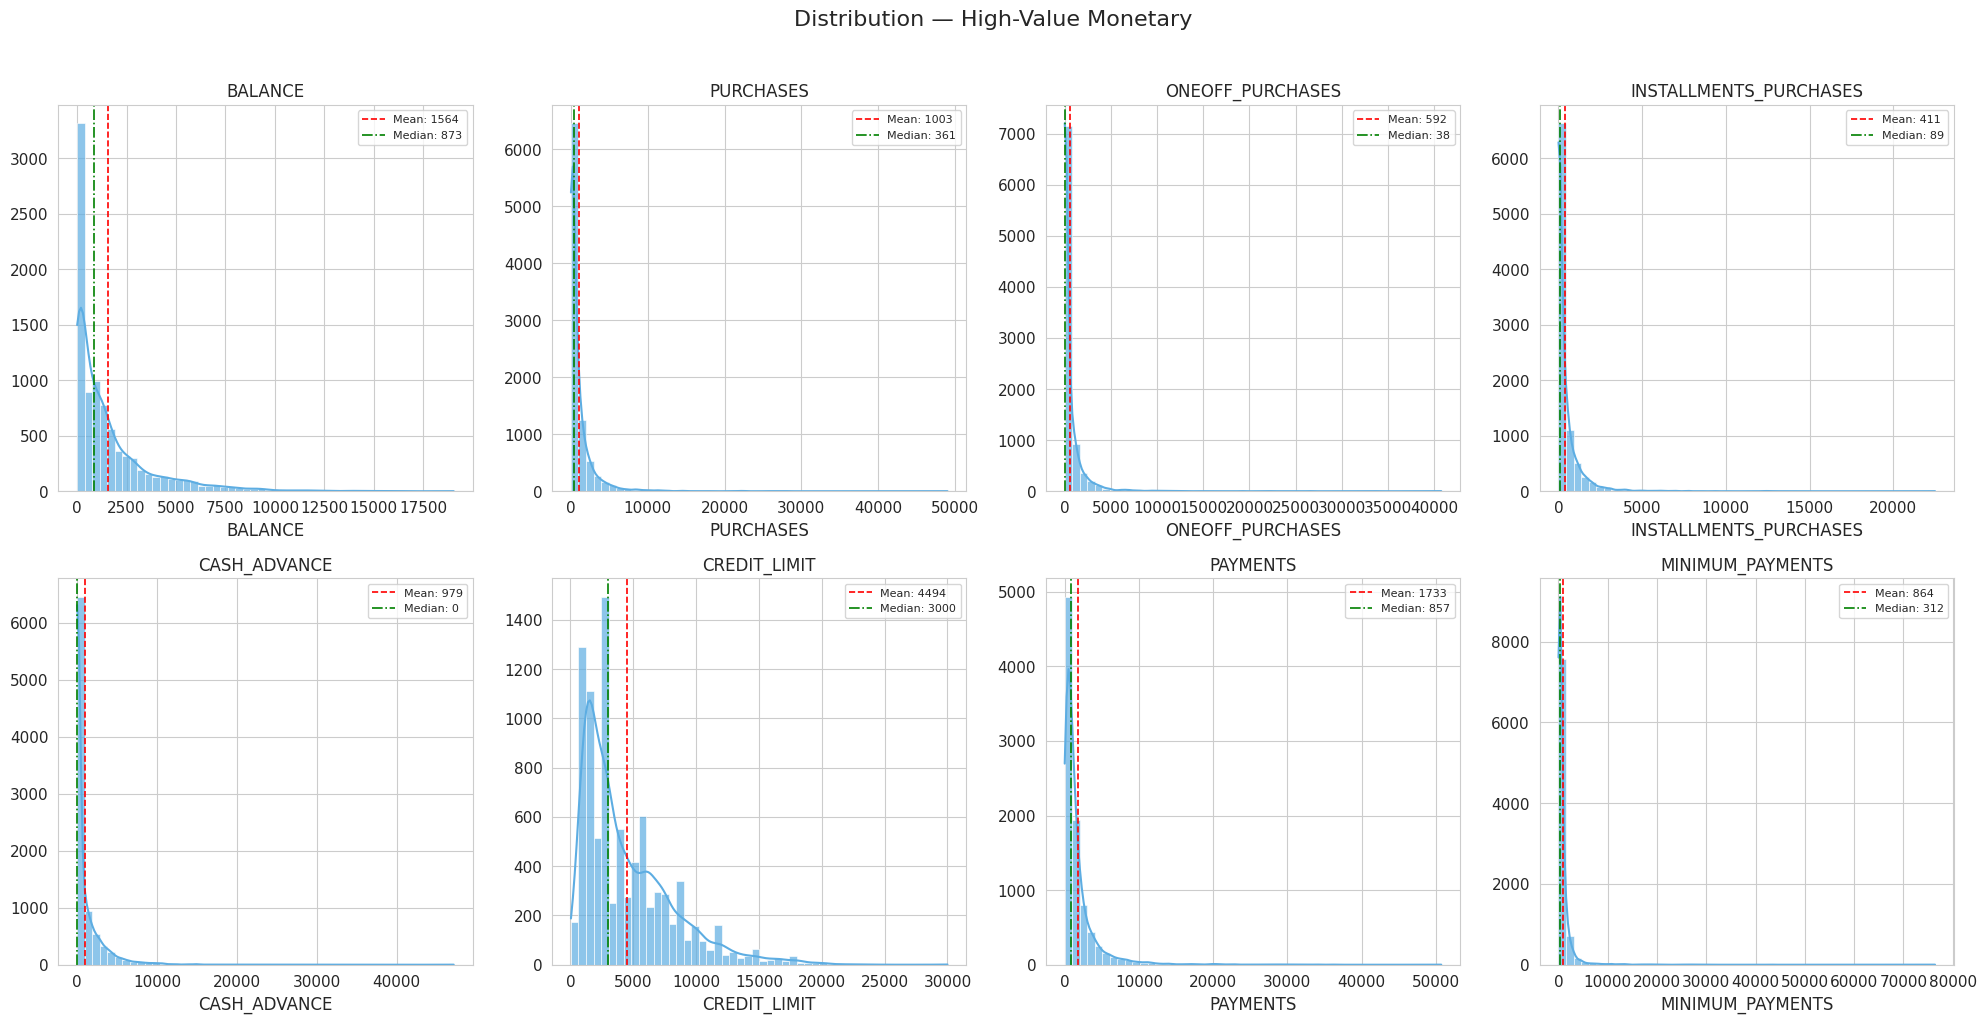

,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS
count,8950.00,8950.00,8950.00,8950.00,8950.00,8949.00,8950.00,8637.00
mean,1564.47,1003.20,592.44,411.07,978.87,4494.45,1733.14,864.21
std,2081.53,2136.63,1659.89,904.34,2097.16,3638.82,2895.06,2372.45
min,0.00,0.00,0.00,0.00,0.00,50.00,0.00,0.02
25%,128.28,39.64,0.00,0.00,0.00,1600.00,383.28,169.12
50%,873.39,361.28,38.00,89.00,0.00,3000.00,856.90,312.34
75%,2054.14,1110.13,577.40,468.64,1113.82,6500.00,1901.13,825.49
max,19043.14,49039.57,40761.25,22500.00,47137.21,30000.00,50721.48,76406.21


In [12]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle("Distribution — High-Value Monetary", fontsize=16, y=1.02)
axes = axes.flatten()
for i, col in enumerate(high_value):
    sns.histplot(df[col], kde=True, ax=axes[i], color="#5DADE2",
                edgecolor="white", bins=50, alpha=0.7)
    axes[i].set_title(col, fontsize=12); axes[i].set_ylabel("")
    axes[i].axvline(df[col].mean(), color="red", ls="--", lw=1.2, label=f"Mean: {df[col].mean():.0f}")
    axes[i].axvline(df[col].median(), color="green", ls="-.", lw=1.2, label=f"Median: {df[col].median():.0f}")
    axes[i].legend(fontsize=8)
for j in range(len(high_value), len(axes)): axes[j].set_visible(False)
plt.tight_layout(); plt.show()

df[high_value].describe().round(2)

#### Analysis — High-Value Monetary Features

| Feature | Box Plot | Distribution | Key Insight |
|---------|----------|-------------|-------------|
| BALANCE | Many outliers above upper whisker | Exponential-like, spike near 0 | Large cluster of near-zero balances; heavy right tail |
| PURCHASES | Extreme upper outliers | Zero spike + right tail | Two populations: **non-purchasers** (0) and **active buyers** |
| ONEOFF_PURCHASES | Whisker compressed to 0 | Zero-inflated | Majority **never** make one-off purchases |
| INSTALLMENTS_PURCHASES | Similar compression at 0 | Zero-inflated | Installment usage is a minority behaviour |
| CASH_ADVANCE | Box nearly flat at 0 | Extreme zero-inflation | Most customers **never** take cash advances; very long tail |
| CREDIT_LIMIT | Wider IQR, fewer outliers | Right-skewed, multi-modal | Modes possibly reflect standard card tiers (1k, 3k, 5k…) |
| PAYMENTS | Significant upper outliers | Exponential-like | Mean >> Median; a few customers make disproportionately large payments |
| MINIMUM_PAYMENTS | Extreme outliers | Power-law shape | Strongest candidate for **log transformation** |



> **Summary**: All monetary features are **heavily right-skewed** with mean 2–5× larger than median. Log or power transformation is essential before clustering to reduce outlier influence.

#### Subgroup 2 — Transaction Count Features (1 < range ≤ 1 000)

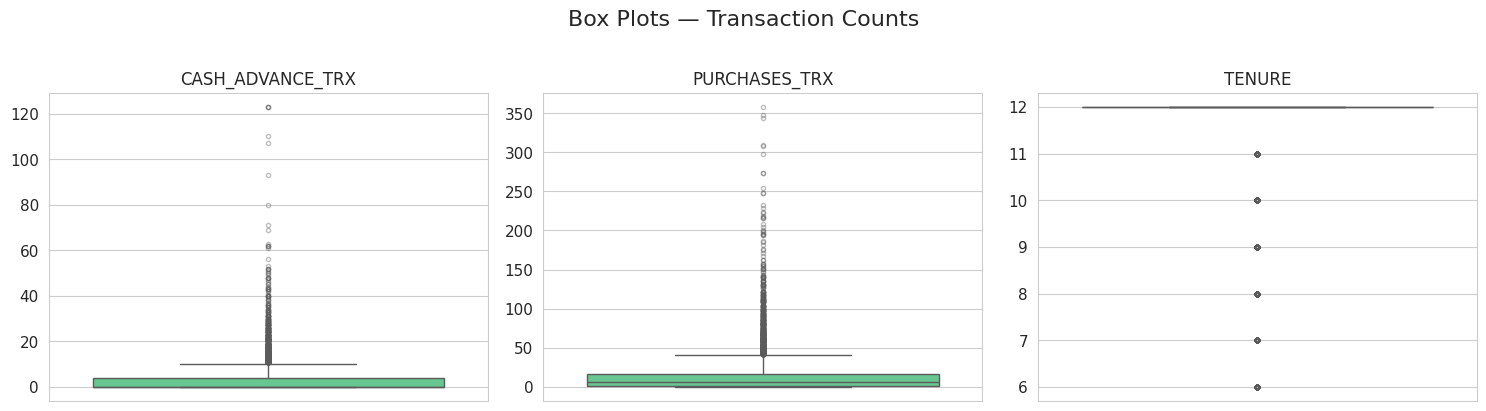

In [13]:
cols = mid_value
n = len(cols)
ncols_g = min(n, 4)
nrows_g = max((n + ncols_g - 1) // ncols_g, 1)

fig, axes = plt.subplots(nrows_g, ncols_g, figsize=(5*ncols_g, 4*nrows_g))
fig.suptitle("Box Plots — Transaction Counts", fontsize=16, y=1.02)
axes = np.array(axes).flatten()
for i, col in enumerate(cols):
    sns.boxplot(y=df[col], ax=axes[i], color="#58D68D",
                flierprops={"marker":"o","markersize":3,"alpha":0.4})
    axes[i].set_title(col, fontsize=12); axes[i].set_ylabel("")
for j in range(n, len(axes)): axes[j].set_visible(False)
plt.tight_layout(); plt.show()

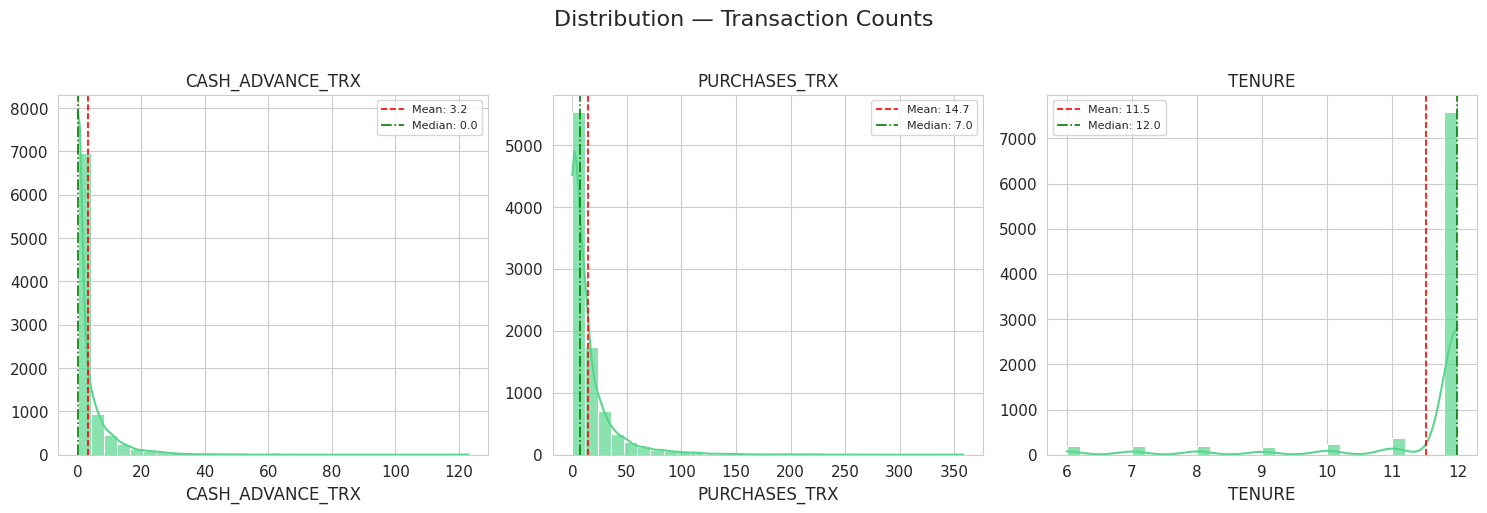

,CASH_ADVANCE_TRX,PURCHASES_TRX,TENURE
count,8950.00,8950.00,8950.00
mean,3.25,14.71,11.52
std,6.82,24.86,1.34
min,0.00,0.00,6.00
25%,0.00,1.00,12.00
50%,0.00,7.00,12.00
75%,4.00,17.00,12.00
max,123.00,358.00,12.00


In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Distribution — Transaction Counts", fontsize=16, y=1.02)
for i, col in enumerate(mid_value):
    sns.histplot(df[col], kde=True, ax=axes[i], color="#58D68D",
                edgecolor="white", bins=30, alpha=0.7)
    axes[i].set_title(col, fontsize=12); axes[i].set_ylabel("")
    axes[i].axvline(df[col].mean(), color="red", ls="--", lw=1.2, label=f"Mean: {df[col].mean():.1f}")
    axes[i].axvline(df[col].median(), color="green", ls="-.", lw=1.2, label=f"Median: {df[col].median():.1f}")
    axes[i].legend(fontsize=8)
plt.tight_layout(); plt.show()

df[mid_value].describe().round(2)

#### Analysis — Transaction Count Features

| Feature | Box Plot | Distribution | Key Insight |
|---------|----------|-------------|-------------|
| CASH_ADVANCE_TRX | Box at 0, many upper outliers | ~75% are 0 | Consistent with monetary cash-advance — most customers never use it |
| PURCHASES_TRX | Wider box, long upper tail | Right-skewed, more spread | Most < 20 txns but tail reaches 300+ |
| TENURE | Very tight box at 12 | Near-constant spike at 12 | ~95% of customers have 12 months — **very low variance** |


> **Summary**: Count features are **discrete and zero-inflated**. TENURE is essentially constant and should be considered for **removal** before clustering to avoid adding noise.

#### Subgroup 3 — Rate / Frequency Features (range ≤ 1)

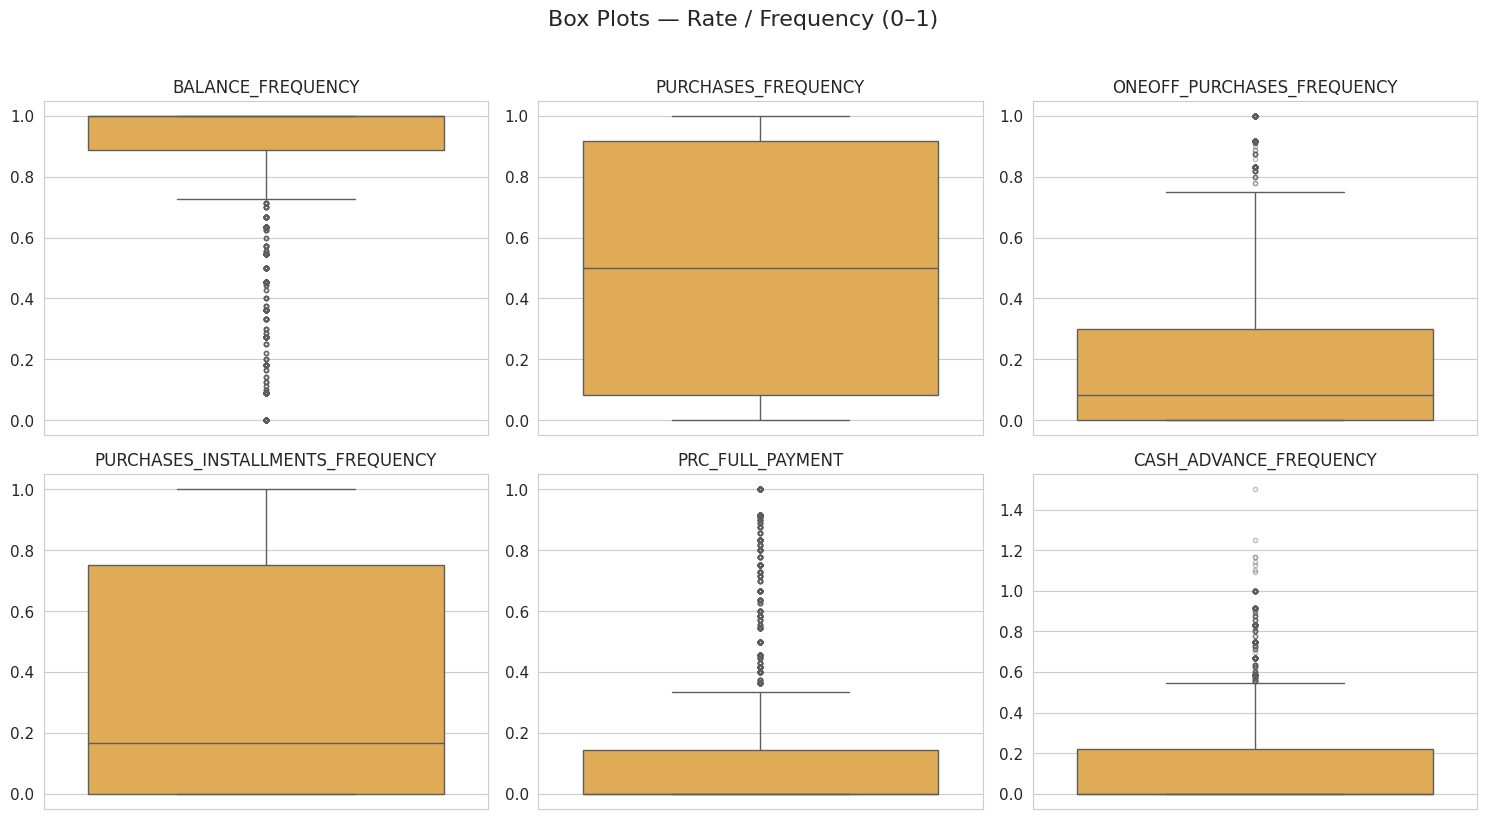

In [15]:
cols = low_value
n = len(cols)
ncols_g = min(n, 3)
nrows_g = max((n + ncols_g - 1) // ncols_g, 1)

fig, axes = plt.subplots(nrows_g, ncols_g, figsize=(5*ncols_g, 4*nrows_g))
fig.suptitle("Box Plots — Rate / Frequency (0–1)", fontsize=16, y=1.02)
axes = np.array(axes).flatten()
for i, col in enumerate(cols):
    sns.boxplot(y=df[col], ax=axes[i], color="#F5B041",
                flierprops={"marker":"o","markersize":3,"alpha":0.4})
    axes[i].set_title(col, fontsize=12); axes[i].set_ylabel("")
for j in range(n, len(axes)): axes[j].set_visible(False)
plt.tight_layout(); plt.show()

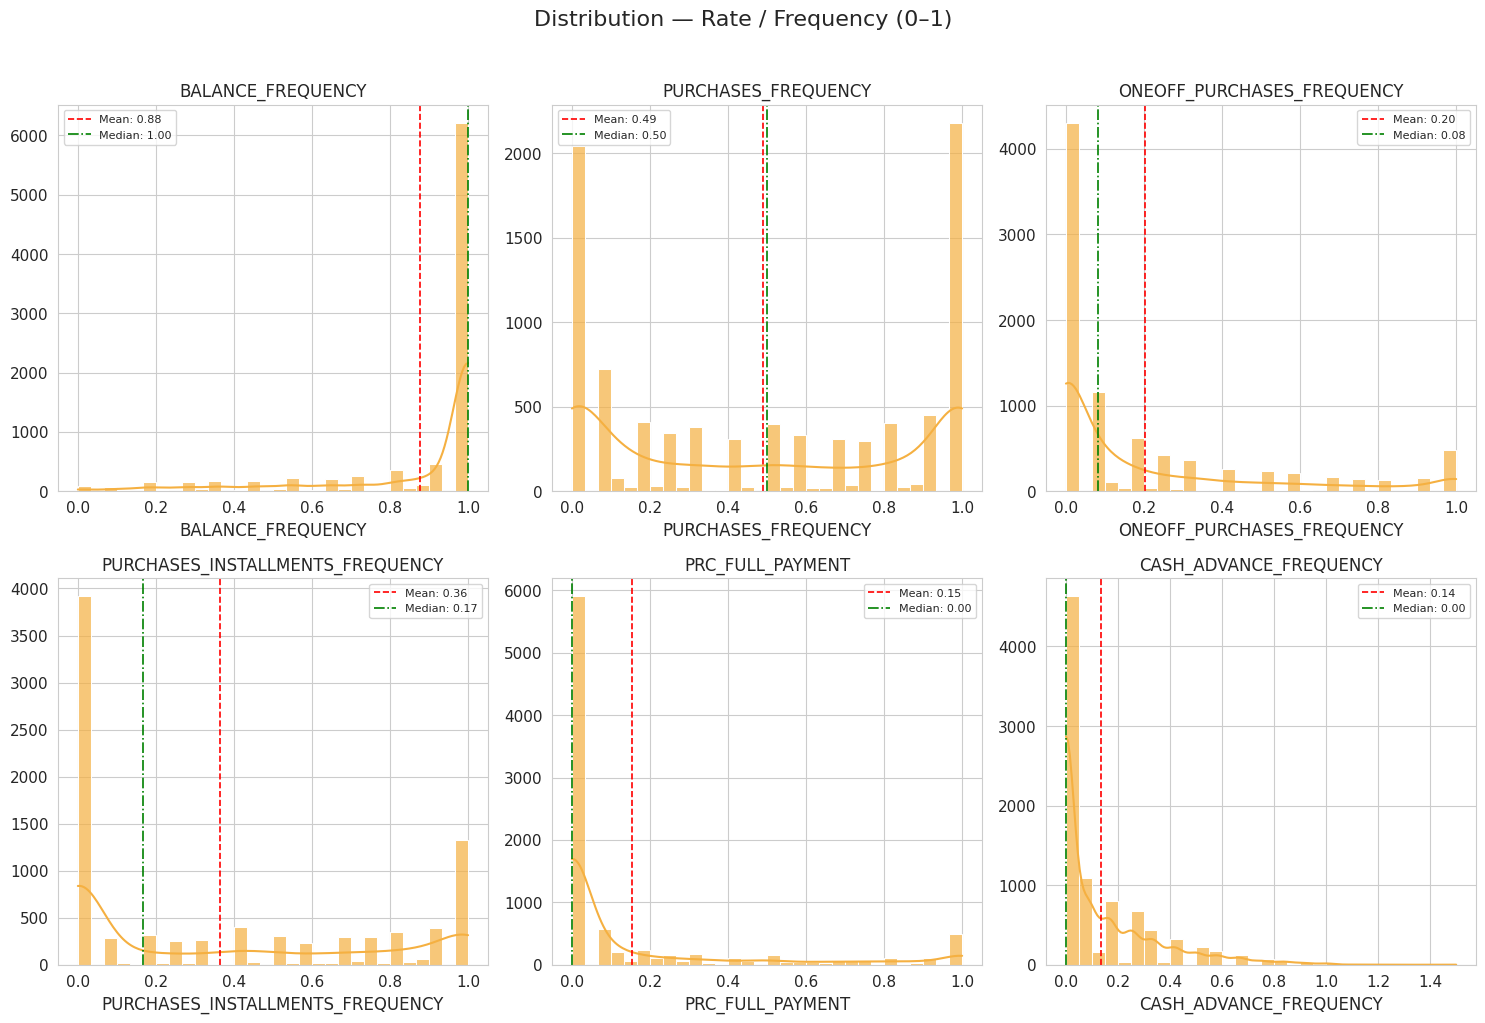

,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PRC_FULL_PAYMENT,CASH_ADVANCE_FREQUENCY
count,8950.00,8950.00,8950.00,8950.00,8950.00,8950.00
mean,0.88,0.49,0.20,0.36,0.15,0.14
std,0.24,0.40,0.30,0.40,0.29,0.20
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.89,0.08,0.00,0.00,0.00,0.00
50%,1.00,0.50,0.08,0.17,0.00,0.00
75%,1.00,0.92,0.30,0.75,0.14,0.22
max,1.00,1.00,1.00,1.00,1.00,1.50


In [16]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Distribution — Rate / Frequency (0–1)", fontsize=16, y=1.02)
axes = axes.flatten()
for i, col in enumerate(low_value):
    sns.histplot(df[col], kde=True, ax=axes[i], color="#F5B041",
                edgecolor="white", bins=30, alpha=0.7)
    axes[i].set_title(col, fontsize=12); axes[i].set_ylabel("")
    axes[i].axvline(df[col].mean(), color="red", ls="--", lw=1.2, label=f"Mean: {df[col].mean():.2f}")
    axes[i].axvline(df[col].median(), color="green", ls="-.", lw=1.2, label=f"Median: {df[col].median():.2f}")
    axes[i].legend(fontsize=8)
for j in range(len(low_value), len(axes)): axes[j].set_visible(False)
plt.tight_layout(); plt.show()

df[low_value].describe().round(2)

#### Analysis — Rate / Frequency Features

| Feature | Box Plot | Distribution | Key Insight |
|---------|----------|-------------|-------------|
| BALANCE_FREQUENCY | Box compressed near 1.0 | Strong left skew, peak at 1 | Most customers update balance **every month** |
| PURCHASES_FREQUENCY | Wide box (high IQR) | U-shaped / bimodal | Two clear populations: non-purchasers (~0) vs regulars (~1) — **strong segmentation signal** |
| ONEOFF_PURCHASES_FREQ | Box at 0 | Heavy spike at 0 | Majority never buy one-off |
| PURCH_INSTALL_FREQ | Box at 0, slight spread | Spike at 0, modest spread | Slightly more engagement than one-off |
| CASH_ADVANCE_FREQUENCY | Box flat at 0 | Extreme spike at 0 | Reinforces rarity of cash advance usage |
| PRC_FULL_PAYMENT | Box flat at 0, upper outliers at 1 | Near-binary (0 vs 1) | Vast majority **never pay in full**; could be engineered into a flag |


> **Summary**: Frequency features are **bounded [0, 1]** and often **zero-inflated or bimodal**. They do not need scaling but their shape should inform the clustering method. PURCHASES_FREQUENCY is one of the most promising segmentation features.

### Correlation Heatmap

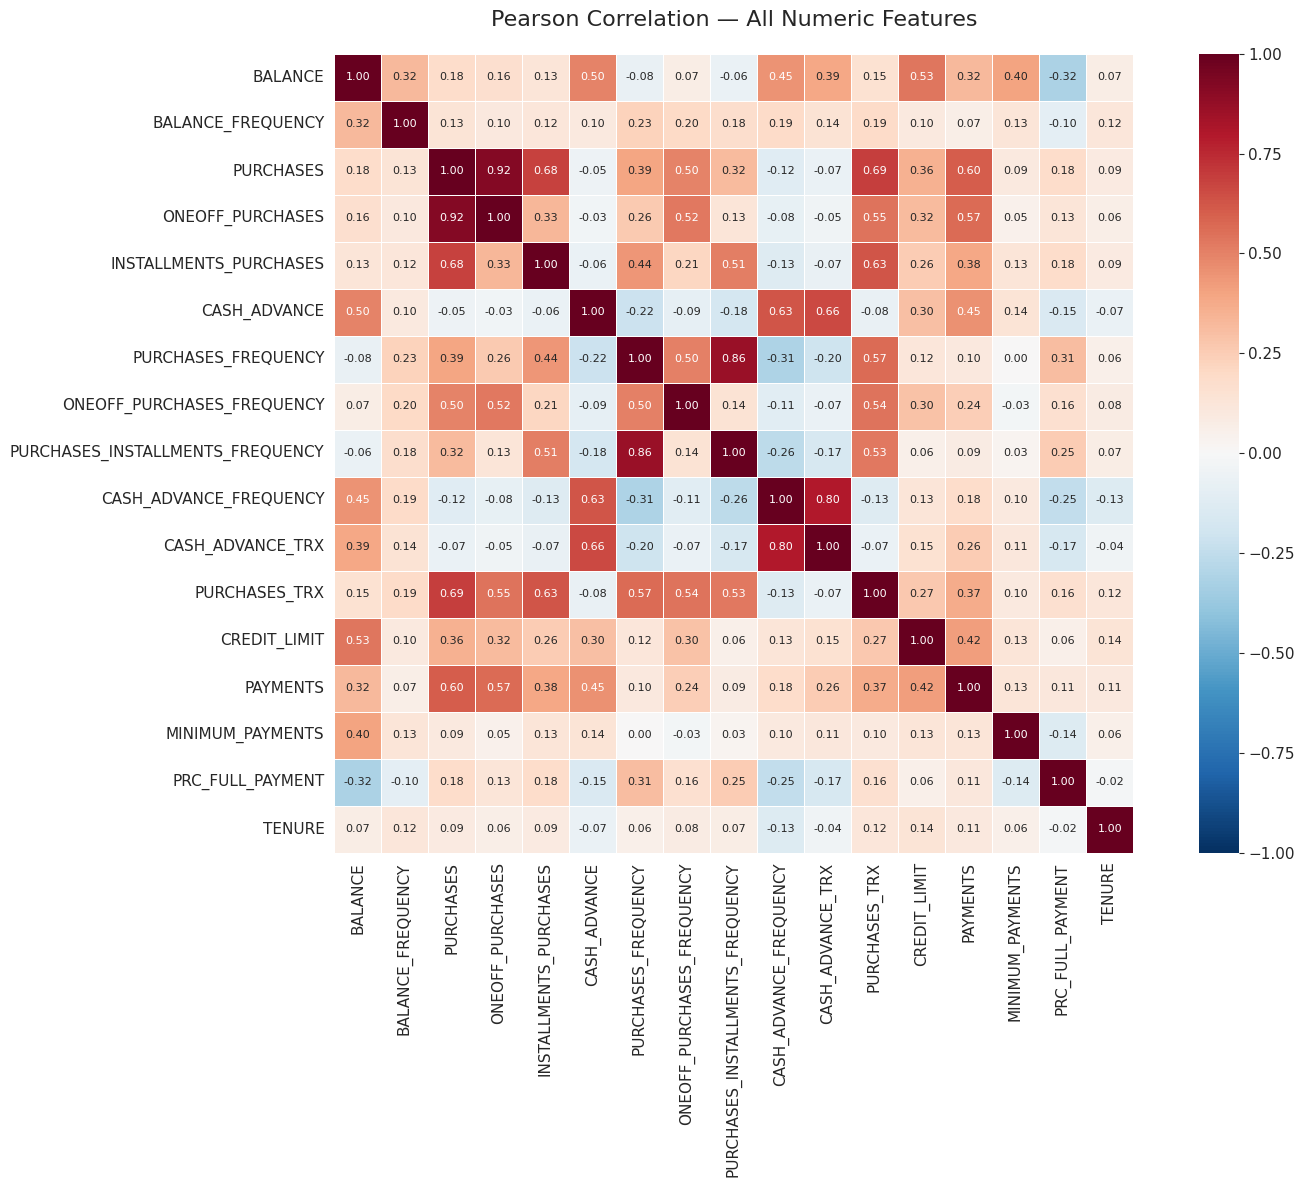

In [17]:
corr = df[numeric_cols].corr()

plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,  annot=True, fmt=".2f", cmap="RdBu_r",
            center=0, vmin=-1, vmax=1, linewidths=0.5,
            annot_kws={"size": 8}, square=True)
plt.title("Pearson Correlation — All Numeric Features", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [18]:
strong = (
    corr.where(~np.triu(np.ones_like(corr, dtype=bool)))
    .stack()
    .reset_index()
)
strong.columns = ["Feature_1", "Feature_2", "Correlation"]
strong = strong[strong["Correlation"].abs() >= 0.5]
strong = strong.sort_values("Correlation", ascending=False, key=abs)
print(f"Feature pairs with |r| >= 0.5  ({len(strong)} pairs):\n")
strong.reset_index(drop=True)

Feature pairs with |r| >= 0.5  (18 pairs):



,Feature_1,Feature_2,Correlation
0,ONEOFF_PURCHASES,PURCHASES,0.916845
1,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_FREQUENCY,0.862934
2,CASH_ADVANCE_TRX,CASH_ADVANCE_FREQUENCY,0.799561
3,PURCHASES_TRX,PURCHASES,0.689561
4,INSTALLMENTS_PURCHASES,PURCHASES,0.679896
5,CASH_ADVANCE_TRX,CASH_ADVANCE,0.656498
6,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE,0.628522
7,PURCHASES_TRX,INSTALLMENTS_PURCHASES,0.628108
8,PAYMENTS,PURCHASES,0.603264
9,PURCHASES_TRX,PURCHASES_FREQUENCY,0.568430


#### Correlation Analysis

**Very strong (|r| ≥ 0.8)**
- PURCHASES ↔ ONEOFF_PURCHASES / INSTALLMENTS_PURCHASES — expected, since total purchases = one-off + installments
- PURCHASES ↔ PURCHASES_TRX / PURCHASES_FREQUENCY — amount, count, and frequency all capture the same purchasing behaviour
- CASH_ADVANCE ↔ CASH_ADVANCE_TRX / CASH_ADVANCE_FREQUENCY — same pattern for cash advances

**Moderate (0.5 ≤ |r| < 0.8)**
- CREDIT_LIMIT ↔ BALANCE / PURCHASES / PAYMENTS — higher credit limits enable higher spending and balances
- ONEOFF_PURCHASES ↔ ONEOFF_PURCHASES_FREQUENCY — redundant encoding


## 3 · Data Preprocessing

In [19]:
df_clean = df.copy()

df_clean["MINIMUM_PAYMENTS"].fillna(0, inplace=True)

df_clean.dropna(subset=["CREDIT_LIMIT"], inplace=True)

print(f"Remaining NAs: {df_clean.isnull().sum().sum()}")
print(f"Shape: {df_clean.shape}")

Remaining NAs: 0
Shape: (8949, 18)


In [20]:
df_clean.drop(columns=["CUST_ID", "TENURE"], inplace=True)

print(f"Remaining columns ({len(df_clean.columns)}): {df_clean.columns.tolist()}")

Remaining columns (16): ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']


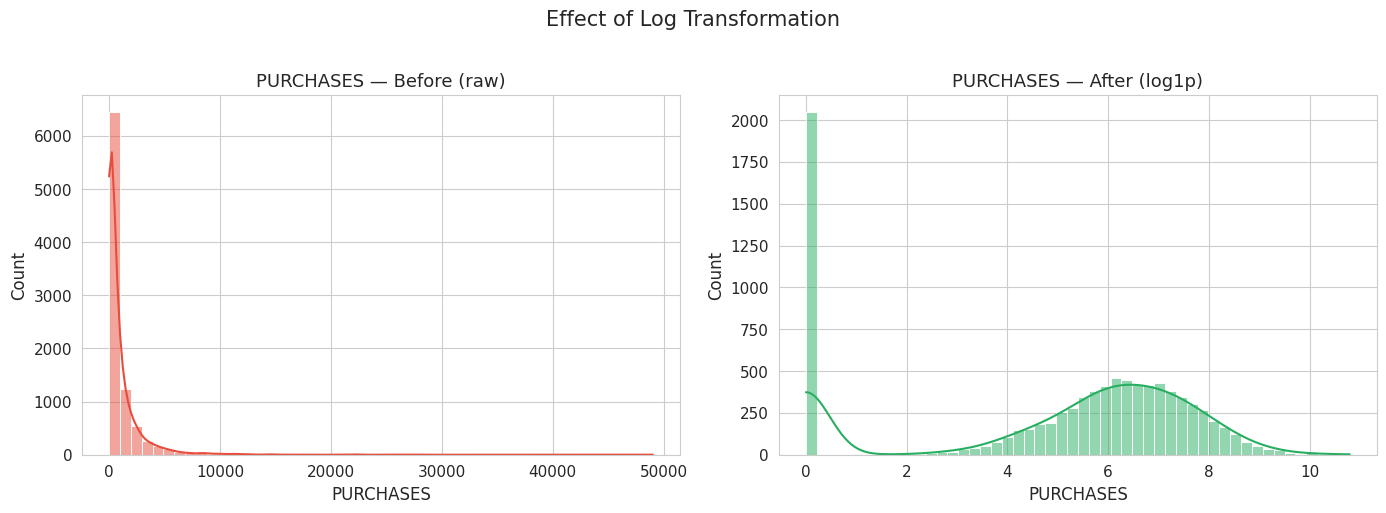

In [21]:
log_cols = ["BALANCE", "PURCHASES", "ONEOFF_PURCHASES",
            "INSTALLMENTS_PURCHASES", "CASH_ADVANCE",
            "CREDIT_LIMIT", "PAYMENTS", "MINIMUM_PAYMENTS"]

for col in log_cols:
    df_clean[col] = np.log1p(df_clean[col])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df["PURCHASES"], kde=True, ax=axes[0], color="#E74C3C",
             bins=50, edgecolor="white")
axes[0].set_title("PURCHASES — Before (raw)", fontsize=13)

sns.histplot(df_clean["PURCHASES"], kde=True, ax=axes[1], color="#27AE60",
             bins=50, edgecolor="white")
axes[1].set_title("PURCHASES — After (log1p)", fontsize=13)

plt.suptitle("Effect of Log Transformation", fontsize=15, y=1.02)
plt.tight_layout(); plt.show()

> **Why log1p?**  `log1p(x) = log(1 + x)` handles zeros safely (log(0) is undefined). 
It compresses the long right tail and brings extreme outliers closer to the bulk, making the distribution more symmetric and better suited for distance-based clustering.

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)

df_scaled = pd.DataFrame(X_scaled, columns=df_clean.columns)
df_scaled.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT
0,-1.205498,-0.249881,-0.113732,-0.987198,0.394362,-0.930636,-0.806649,-0.678716,-0.707409,-0.675294,-0.476083,-0.511381,-1.447095,-0.825080,-0.482233,-0.525588
1,0.948821,0.134049,-1.680213,-0.987198,-1.087586,1.528788,-1.221928,-0.678716,-0.917090,0.573949,0.110032,-0.591841,0.925997,1.065109,0.790915,0.234159
2,0.824885,0.517980,0.600600,1.061910,-1.087586,-0.930636,1.269742,2.673295,-0.917090,-0.675294,-0.476083,-0.109082,1.010161,-0.119646,0.455581,-0.525588
3,0.624529,-1.017743,0.827395,1.265665,-1.087586,0.564410,-1.014290,-0.399383,-0.917090,-0.258882,-0.329554,-0.551611,1.010161,-4.163779,-3.578781,-0.525588
4,0.271106,0.517980,-0.708741,-0.114417,-1.087586,-0.930636,-1.014290,-0.399383,-0.917090,-0.675294,-0.476083,-0.551611,-1.224854,-0.065306,-0.132079,-0.525588


In [23]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8949 entries, 0 to 8948
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8949 non-null   float64
 1   BALANCE_FREQUENCY                 8949 non-null   float64
 2   PURCHASES                         8949 non-null   float64
 3   ONEOFF_PURCHASES                  8949 non-null   float64
 4   INSTALLMENTS_PURCHASES            8949 non-null   float64
 5   CASH_ADVANCE                      8949 non-null   float64
 6   PURCHASES_FREQUENCY               8949 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8949 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8949 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8949 non-null   float64
 10  CASH_ADVANCE_TRX                  8949 non-null   float64
 11  PURCHASES_TRX                     8949 non-null   float64
 12  CREDIT

#### Preprocessing Complete

| Step | Action | Details |
|------|--------|---------|
| 1 | Handle missing values | MINIMUM_PAYMENTS → filled with 0; 1 row with missing CREDIT_LIMIT dropped |
| 2 | Drop uninformative columns | CUST_ID (identifier), TENURE (near-constant at 12) |
| 3 | Log transform | Applied `log1p` to 8 high-value monetary features to reduce skew |
| 4 | Standardize | StandardScaler on all 15 remaining features |

The data is now ready for clustering. `X_scaled` is the final feature matrix.

## 4 · Optimal Number of Clusters

Using the preprocessed & scaled data, we project into 2D using **four approaches** to see which reveals the clearest natural structure.

### Hierarchical Clustering (Dendrogram)

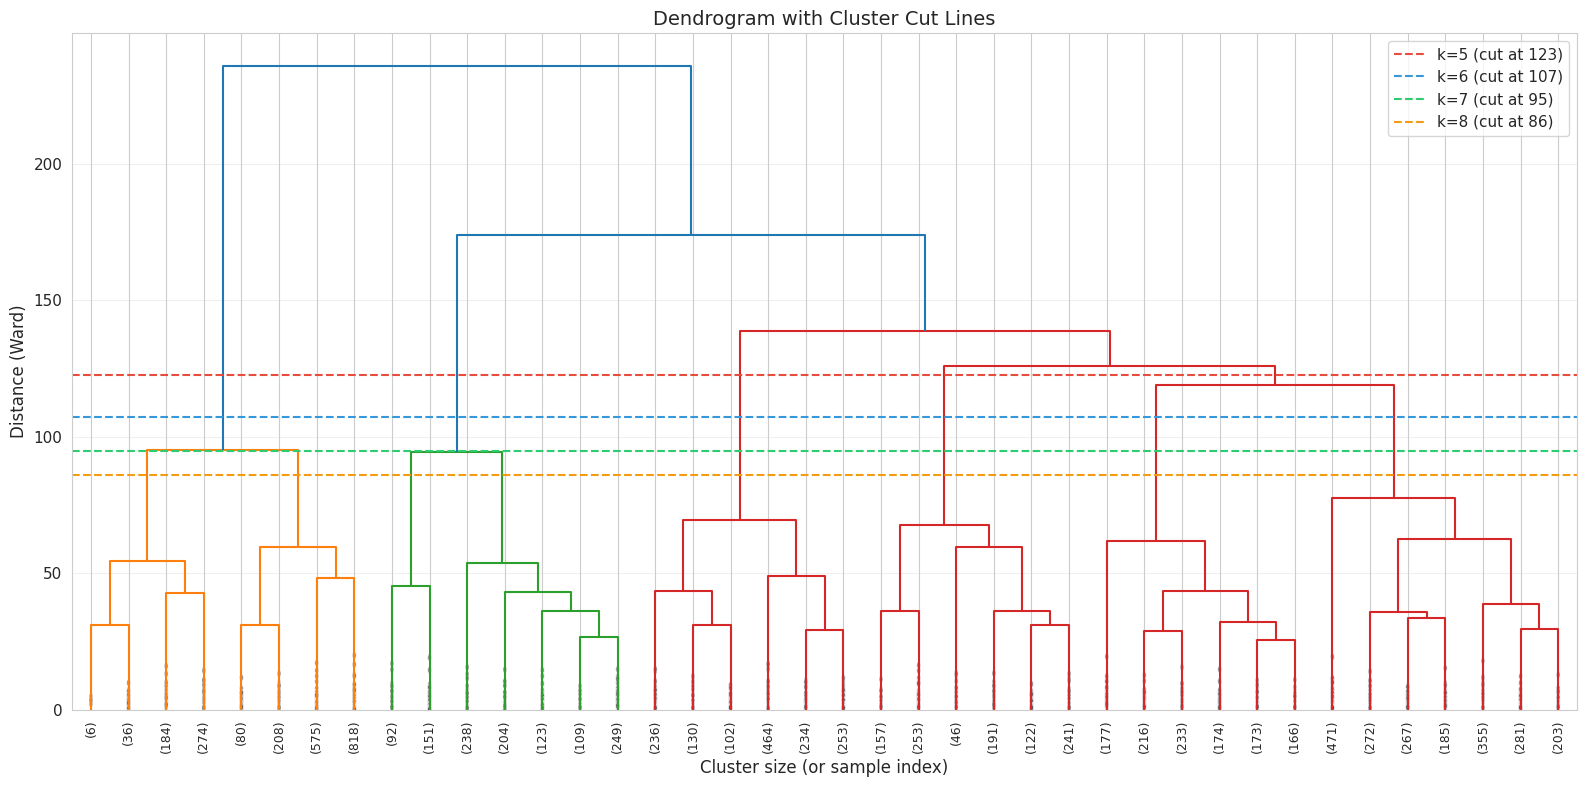

Last 10 merge distances (look for the biggest jump):
  merge → k= 2   distance=     236.0   gap=    62.1 ◀ LARGE GAP
  merge → k= 3   distance=     173.8   gap=    35.2 ◀ LARGE GAP
  merge → k= 4   distance=     138.7   gap=    12.7 ◀ LARGE GAP
  merge → k= 5   distance=     126.0   gap=     7.0
  merge → k= 6   distance=     119.0   gap=    23.7 ◀ LARGE GAP
  merge → k= 7   distance=      95.3   gap=     0.8
  merge → k= 8   distance=      94.5   gap=    17.0 ◀ LARGE GAP
  merge → k= 9   distance=      77.5   gap=     8.1
  merge → k=10   distance=      69.4   gap=     1.6
  merge → k=11   distance=      67.8   gap=     5.2


In [24]:
Z = linkage(X_scaled, method="ward")


fig, ax = plt.subplots(figsize=(16, 8))
dendrogram(Z, truncate_mode="lastp", p=40, leaf_rotation=90,
           leaf_font_size=9, show_contracted=True, ax=ax)
ax.set_title("Dendrogram with Cluster Cut Lines", fontsize=14)
ax.set_xlabel("Cluster size (or sample index)", fontsize=12)
ax.set_ylabel("Distance (Ward)", fontsize=12)

colors = ["#E74C3C", "#3498DB", "#2ECC71", "#F39C12"]
for k, color in zip([5, 6, 7, 8], colors):
    cut_height = (Z[-(k-1), 2] + Z[-k, 2]) / 2
    ax.axhline(y=cut_height, color=color, ls="--", lw=1.5,
               label=f"k={k} (cut at {cut_height:.0f})")

ax.legend(fontsize=11, loc="upper right")
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout(); plt.show()


# Print the last 10 merge distances (biggest gaps)
print("Last 10 merge distances (look for the biggest jump):")
for i in range(min(10, len(Z))):
    idx = len(Z) - 1 - i
    gap = Z[idx, 2] - Z[idx-1, 2] if idx > 0 else 0
    k = len(Z) - idx + 1
    marker = " ◀ LARGE GAP" if gap > Z[-1, 2] * 0.05 else ""
    print(f"  merge → k={k:2d}   distance={Z[idx,2]:10.1f}   gap={gap:8.1f}{marker}")

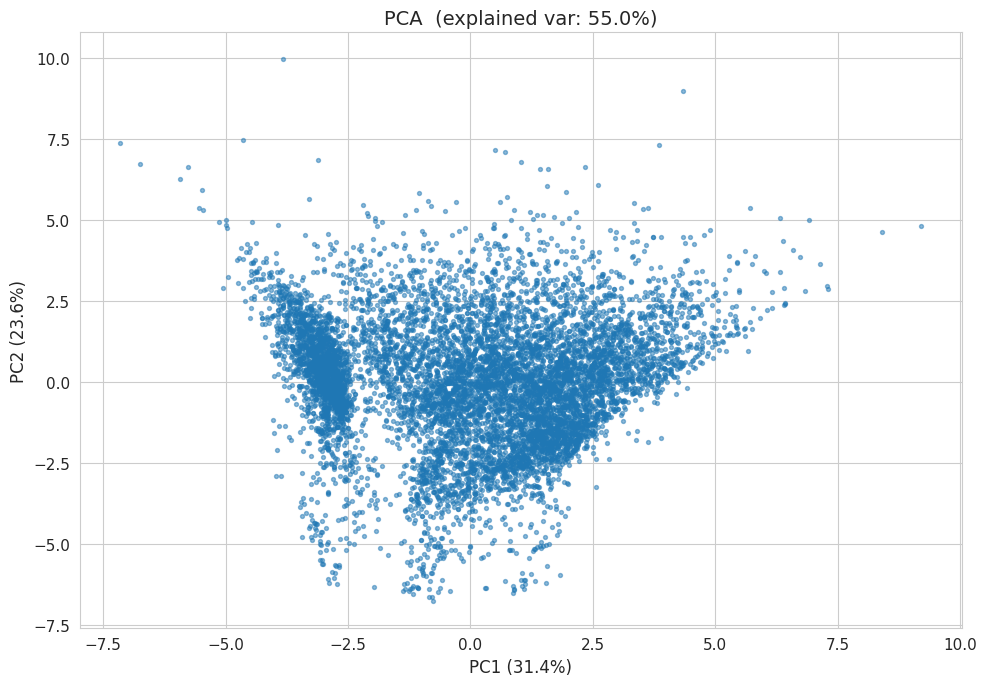

In [25]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], cmap="Set2",
                     s=8, alpha=0.5)
ax.set_title(f"PCA  (explained var: {pca.explained_variance_ratio_.sum()*100:.1f}%)",
             fontsize=14)
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.tight_layout(); plt.show()

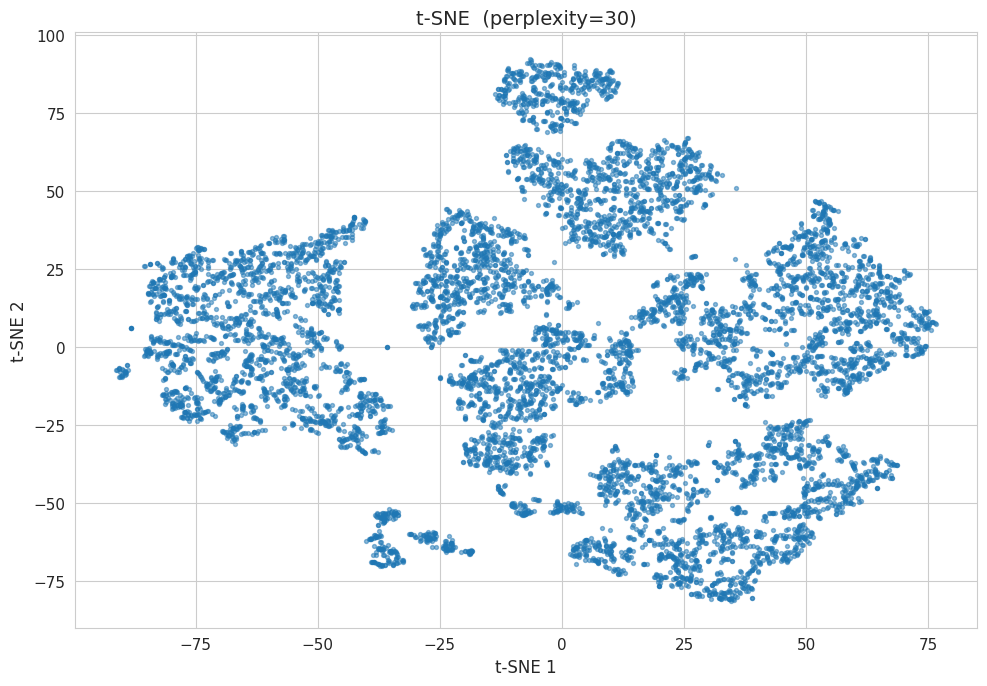

In [26]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], cmap="Set2",
                     s=8, alpha=0.5)
ax.set_title("t-SNE  (perplexity=30)", fontsize=14)
ax.set_xlabel("t-SNE 1"); ax.set_ylabel("t-SNE 2")
plt.tight_layout(); plt.show()

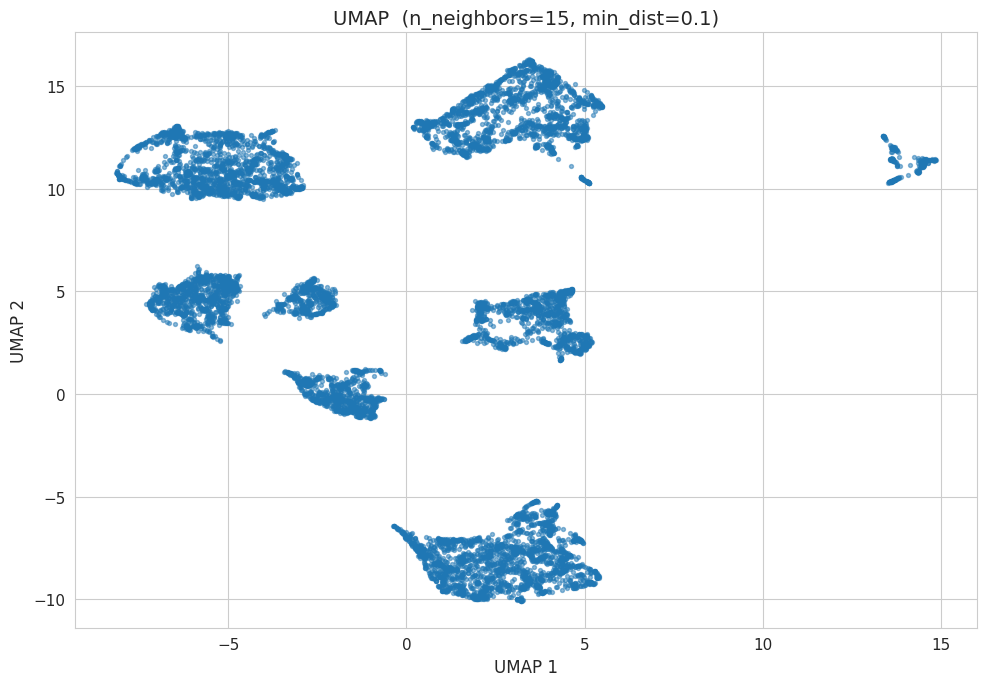

In [27]:
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1] ,cmap="Set2",
                     s=8, alpha=0.5)
ax.set_title("UMAP  (n_neighbors=15, min_dist=0.1)", fontsize=14)
ax.set_xlabel("UMAP 1"); ax.set_ylabel("UMAP 2")
plt.tight_layout(); plt.show()

PCA 10-comp explained variance: 95.2%


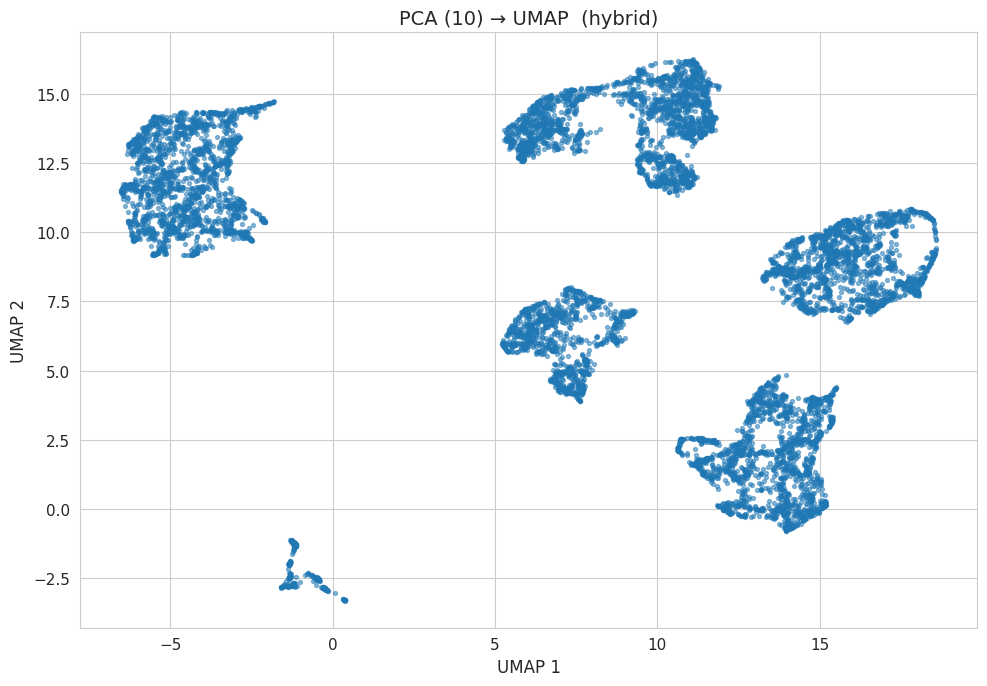

In [28]:
pca10 = PCA(n_components=10, random_state=42)
X_pca10 = pca10.fit_transform(X_scaled)
print(f"PCA 10-comp explained variance: {pca10.explained_variance_ratio_.sum()*100:.1f}%")

reducer2 = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_hybrid = reducer2.fit_transform(X_pca10)

fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(X_hybrid[:, 0], X_hybrid[:, 1], cmap="Set2",
                     s=8, alpha=0.5)
ax.set_title("PCA (10) → UMAP  (hybrid)", fontsize=14)
ax.set_xlabel("UMAP 1"); ax.set_ylabel("UMAP 2")
plt.tight_layout(); plt.show()

## 5 · Cluster Visualization

### GMM Clusters — k = 6, 7, 8 across 4 projections

Each row shows a different k (from the dendrogram candidates). Each column shows a different 2D projection:
1. **PCA** — linear, preserves global variance
2. **t-SNE** — non-linear, preserves local neighbourhood
3. **UMAP** — non-linear, preserves both local and global structure
4. **PCA(10) → UMAP** — hybrid: reduce noise with PCA first, then UMAP

In [ ]:
gmm_ks = [6, 7, 8]
gmm_results = {k: gmm_results[k] for k in gmm_ks}

projections = {
    'PCA': X_pca,
    't-SNE': X_tsne,
    'UMAP': X_umap,
    'PCA→UMAP': X_hybrid
}

# --- 3×4 Grid: GMM k=6,7,8 ---
fig, axes = plt.subplots(len(gmm_ks), 4, figsize=(24, 6 * len(gmm_ks)))
fig.suptitle('GMM Clustering — k = 6, 7, 8  ×  4 Projections', fontsize=18, y=1.01)

for row, k in enumerate(gmm_ks):
    lbl = gmm_results[k]['labels']
    for col, (proj_name, X_proj) in enumerate(projections.items()):
        ax = axes[row, col]
        scatter = ax.scatter(X_proj[:, 0], X_proj[:, 1], c=lbl, cmap='tab10',
                             s=6, alpha=0.5)
        ax.set_title(f'k={k}  |  {proj_name}', fontsize=12)
        ax.set_xlabel(f'{proj_name} 1', fontsize=9)
        ax.set_ylabel(f'{proj_name} 2', fontsize=9)
        ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()


NameError: name 'gmm_results' is not defined

#### GMM Visualization Analysis

| Projection | What it reveals |
|------------|----------------|
| **PCA** | Shows the *global* variance structure. If clusters overlap heavily in PCA, the separation is driven by non-linear relationships that PCA cannot capture. Look for whether increasing k simply splits existing blobs or creates new meaningful groups. |
| **t-SNE** | Emphasises *local* neighbourhoods. Well-separated islands suggest genuine clusters. If colours mix within an island, that k may be over-segmenting that group. |
| **UMAP** | Preserves both local and some global structure. The most trustworthy 2D view. Compare the UMAP plot across k=6,7,8 — the k where each UMAP island has a single colour is likely best. |
| **PCA→UMAP** | Hybrid that removes high-dimensional noise before UMAP. If this looks cleaner than raw UMAP, the extra PCA step is worthwhile. |

> **Decision rule**: Pick the k where *all four projections agree* on well-separated, single-coloured clusters. If k=7 or k=8 just splits a k=6 cluster into two overlapping pieces, stick with fewer.

### DBSCAN Clusters across 4 projections

DBSCAN automatically detects the number of clusters and labels **noise** (outliers) as cluster −1. Noise points are shown in **gray**.

In [ ]:
# --- DBSCAN: 1×4 row ---
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
fig.suptitle(f'DBSCAN  (eps={eps_val}, min_samples={min_samp})', fontsize=16, y=1.02)

# Create a colour map that shows noise in gray
unique_labels = sorted(set(dbscan_labels))
colors = plt.cm.tab10(np.linspace(0, 1, max(len(unique_labels), 10)))
color_map = {}
ci = 0
for l in unique_labels:
    if l == -1:
        color_map[l] = (0.7, 0.7, 0.7, 0.3)   # gray, transparent
    else:
        color_map[l] = colors[ci]
        ci += 1

point_colors = [color_map[l] for l in dbscan_labels]

for col, (proj_name, X_proj) in enumerate(projections.items()):
    ax = axes[col]
    # Draw noise first (behind)
    noise_mask = dbscan_labels == -1
    ax.scatter(X_proj[noise_mask, 0], X_proj[noise_mask, 1],
               c=[(0.7,0.7,0.7,0.3)], s=4, label='Noise')
    # Draw clusters on top
    for cl in sorted(set(dbscan_labels)):
        if cl == -1:
            continue
        mask = dbscan_labels == cl
        ax.scatter(X_proj[mask, 0], X_proj[mask, 1],
                   c=[color_map[cl]], s=6, alpha=0.6, label=f'Cluster {cl}')
    ax.set_title(f'{proj_name}', fontsize=12)
    ax.set_xlabel(f'{proj_name} 1', fontsize=9)
    ax.set_ylabel(f'{proj_name} 2', fontsize=9)
    ax.tick_params(labelsize=8)
    if col == 0:
        ax.legend(fontsize=7, loc='best', markerscale=2)

plt.tight_layout()
plt.show()


#### DBSCAN Visualization Analysis

| Aspect | What to look for |
|--------|------------------|
| **Noise points (gray)** | These are the outliers that would have pulled KMeans centroids. Check if they correspond to extreme spenders or unusual patterns. |
| **Cluster shapes** | DBSCAN can find non-spherical clusters. In the UMAP/t-SNE views, clusters may follow the natural manifold shape. |
| **Few large clusters** | If DBSCAN finds only 1–2 large clusters + noise, it means the data has varying density — GMM may be more appropriate here. |
| **Many small clusters** | If there are many clusters, try increasing `eps` or `min_samples`. |

### GMM vs DBSCAN — Comparison

| Criterion | GMM | DBSCAN |
|-----------|-----|--------|
| **Outlier handling** | Low probability under all components — no centroid distortion | Explicitly labelled as noise (−1) |
| **Number of clusters** | Must be specified (use BIC/AIC) | Automatically determined by density |
| **Cluster shapes** | Ellipsoidal (with full covariance) | Arbitrary |
| **Soft assignment** | ✅ — gives probability per cluster | ❌ — hard assignment only |
| **Varying density** | Handles it (each component has its own covariance) | Struggles — may merge dense clusters or split sparse ones |

> **For credit card customer segmentation**, GMM is typically the better choice because:
> 1. Customer segments often have **different sizes and shapes** (VIPs vs regular users)
> 2. **Soft assignment** tells you which customers are on the boundary between segments
> 3. BIC/AIC provides a principled way to choose k
>
> DBSCAN is useful as a **validation tool** — its noise labels highlight the same outliers that would distort KMeans, confirming that KMeans was the wrong choice.

PCA 10-comp explained variance: 95.2%


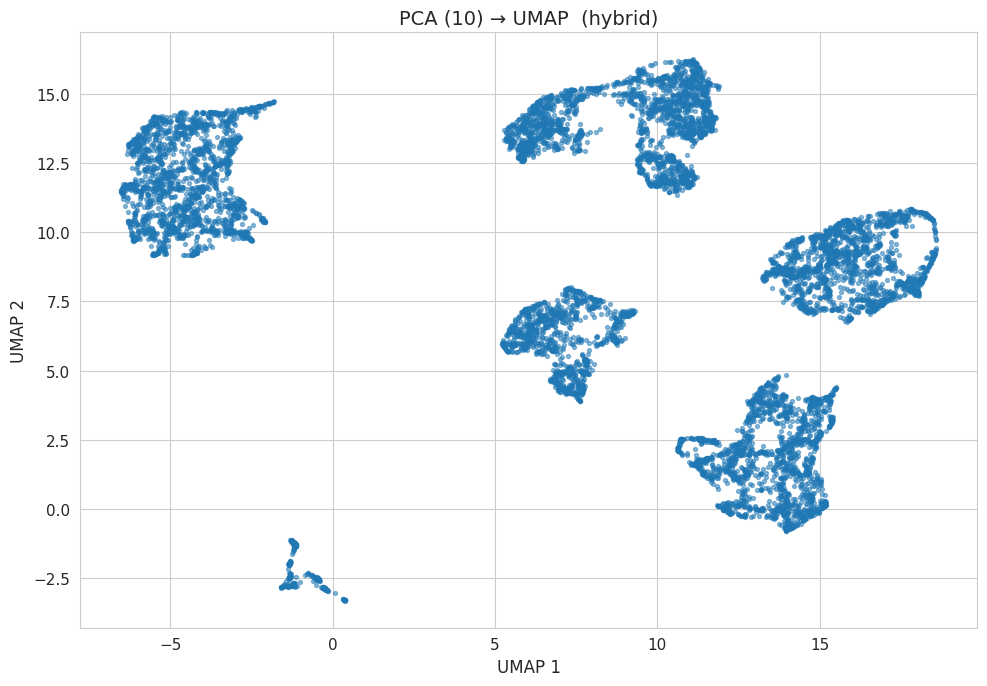

In [ ]:
pca10 = PCA(n_components=10, random_state=42)
X_pca10 = pca10.fit_transform(X_scaled)
print(f"PCA 10-comp explained variance: {pca10.explained_variance_ratio_.sum()*100:.1f}%")

reducer2 = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_hybrid = reducer2.fit_transform(X_pca10)

fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(X_hybrid[:, 0], X_hybrid[:, 1], cmap="Set2",
                     s=8, alpha=0.5)
ax.set_title("PCA (10) → UMAP  (hybrid)", fontsize=14)
ax.set_xlabel("UMAP 1"); ax.set_ylabel("UMAP 2")
plt.tight_layout(); plt.show()

if we applied pca and get only the first 10 high variance components. we can cluster the data as only 6 clusters 